# J1407 Analysis
In this notebook the light curve detected by Kenworthy & Mamajek 2015 of a young star, J1407, in the upper ScoCen area will be analysed with BeyonCE to determine if there are smaller, better fit model solutions to the data gathered.

## Module Imports
Here we import all the necessary modules for the analysis of the J1407 light curve.

In [1]:
# main modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import astropy.units as u

# shallot grid
from Shallot import ShallotGrid
from GridParameters import GridParameters

# ring system
from RingSystem import RingSystem


In [2]:
def load_photometry(filename: str, time_shift: float) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    This function loads the photometry for J1407

    Parameters
    ----------
    filename : str
        Name of the file to be read.
    time_shift : float
        Value by which to shift the time in loading.

    Returns
    -------
    time : np.ndarray (float 1-D)
        Array of times photometry was taken at.
    flux : np.ndarray (float 1-D)
        Array of normalised flux values of the photometry.
    error : np.ndarray (float 1-D)
        Array of the error values associated with each 
        measurement.
    '''
    time, flux, error = np.loadtxt(filename, skiprows=1).T
    time -= time_shift
    return time, flux, error

def load_gradients(filename: str, time_shift: float) -> tuple[np.ndarray, np.ndarray]:
    '''
    This function loads the gradient files calculated for J1407
    
    Parameters
    ----------
    filename : str
        Name of the file to be read.
    time_shift : float
        Value by which to shift the time in loading.

    Returns
    -------
    time : np.ndarray (float 1-D)
        Array of times photometry was taken at.
    '''
    data = np.loadtxt(filename).T
    time = data[0] - time_shift + 54222
    gradient = np.abs(data[1])
    return time, gradient

def ring_gradients(x_positions: np.ndarray, dx: float, dy: float, inclination: float, tilt: float) -> np.ndarray:
    '''
    This function is used to determine the projected gradients for 
    a given ellipse defined by inclination and tilt.

    Parameters
    ----------
    x_positions : np.ndarray (float 1-D)
        These are the positions [space] along which to measure the
        the gradient [R*].
    dx : float
        x-coordinate of the centre of the occulter [R*].
    dy : float
        y-coordinate of the centre of the occulter [R*].
    inclination : float
        Inclination of the occulter (angle w.r.t. LOS) [deg].
    tilt : float
        Angle between occulter semi-major axis and the orbital path [deg].

    Returns
    -------
    gradients : array_like (float 1-D)
        The projected gradients are a transformation of the above tangents.
    '''
    # convert angles to radians
    inc = np.deg2rad(inclination)
    phi = np.deg2rad(tilt)
    
    # transform coordinates to ellipse centre
    x = x_positions - dx
    y = -dy * np.ones_like(x)
    
    # helpers
    numz = np.cos(phi)**2 + np.sin(phi)**2 / np.cos(inc)**2
    denz = np.sin(phi)**2 + np.cos(phi)**2 / np.cos(inc)**2
    z = np.cos(phi) * np.sin(phi) * (1 - 1 / np.cos(inc)**2)
    
    # tangents
    tangents = -(x * numz + z * y) / (y * denz + z * x)

    # gradients
    gradients = np.abs(np.sin(np.arctan2(tangents, 1)))

    return gradients

## J1407 Data
The J1407 light curve shows a single exteded eclipse. It occured in 2007 and spans approximately 56 days. The eclipse was captured by Super WASP. The light curve data and gradient information is loaded in. The data from the best fit model is also defined here.

In [3]:
time_centre = 54220.65

time, flux, error = load_photometry('data/j1407/data/j1407_bincc.dat', time_centre)
slope_times, slopes = load_gradients('data/j1407/data/j1407_gradients.txt', time_centre)

#### Star and Model Data from Kenworthy & Mamajek 2015
Here is data from Kenworthy & Mamajek 2015 as presented in the paper with the corresponding units.

In [4]:
# paper information
paper_disk_radius_j1407 = 90.2e6 * u.km
paper_inclination_j1407 = 70 * u.deg
paper_tilt_j1407 = 166.10 * u.deg
paper_dx_j1407 = 4.81 * u.d
paper_dy_j1407 = 3.92 * u.d
paper_star_radius = 0.9 * u.Rsun 


paper_eclipse_duration = 54 * u.d
paper_transverse_velocity = 33 * u.km / u.s
paper_limb_darkening = 0.8 # -

<strong>Note:</strong> <em>In the paper the impact parameter is defined as the y-offset of the star w.r.t. the occulting disk. The star also moves from left to right, which means we observe the gradients from the left edge of the occulter to the right edge.</em>

The data above are converted for use in this analysis.

In [5]:
eclipse_duration = paper_eclipse_duration.value
limb_darkening = paper_limb_darkening
transverse_velocity = (paper_transverse_velocity * (1 * u.d).to(u.s) / paper_star_radius.to(u.km)).value

disk_radius_j1407 = (paper_disk_radius_j1407 / paper_star_radius.to(u.km) / paper_eclipse_duration / transverse_velocity).value
inclination_j1407 = paper_inclination_j1407.value
tilt_j1407 = 180 - paper_tilt_j1407.value
impact_parameter_j1407 = - (paper_dy_j1407 / paper_eclipse_duration).value
centroid_shift_j1407 = - (paper_dx_j1407 / paper_eclipse_duration).value

In [6]:
velocity_scale = np.pi / transverse_velocity
limb_darkening_scale = (6 - 2 * limb_darkening) / (12 - 12 * limb_darkening + 3 * np.pi * limb_darkening)

gradient_scale = velocity_scale * limb_darkening_scale
gradients_corr = gradient_scale * slopes

<strong>Note:</strong> <em>in this analysis the impact parameter is defined as the y-offset of the </em><strong>occulter w.r.t. the star</strong><em> and the </em><strong>occulter</strong><em> moves from left to right. This means we observe the gradients from the </em><strong>right</strong><em> edge to the </em><strong>left</strong><em> edge. For this reason the tilt is flipped about the y-axis, and the impact parameter and centroid shift have a flipped sign.</em>

#### Light Curve Data
We plot both eclipses to ensure that the data has been loaded properly.

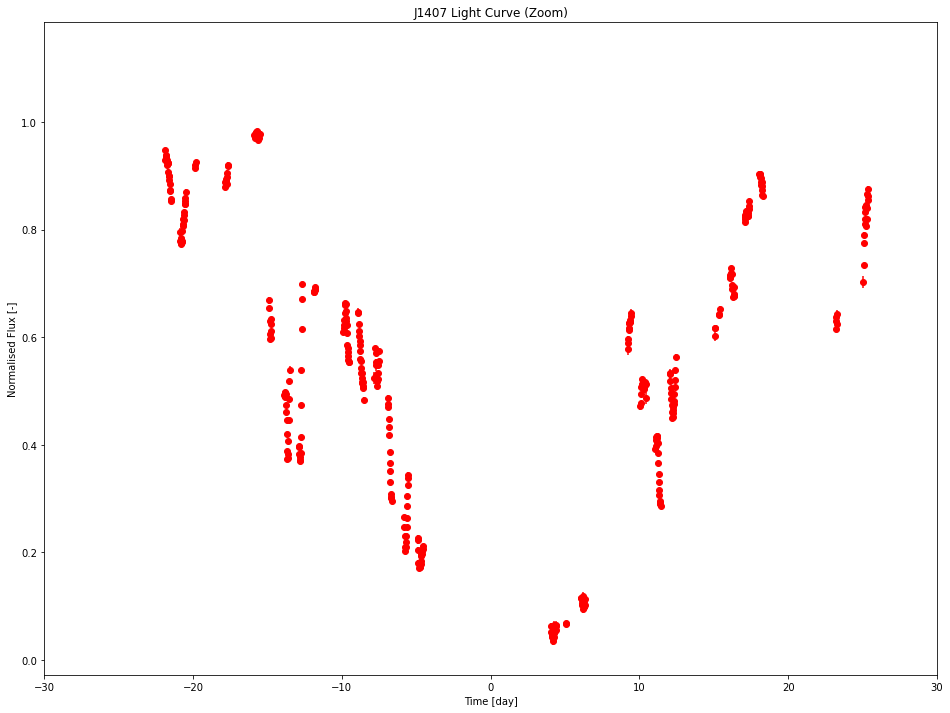

In [7]:
fig, ax = plt.subplots(figsize=(16,12))
ax.errorbar(time, flux, yerr=error, fmt='o', color='r')
ax.set_xlabel('Time [day]')
ax.set_ylabel('Normalised Flux [-]')
ax.set_title('J1407 Light Curve (Zoom)')
ax.set_xlim(-30, 30)
plt.show()

#### Gradient Data
We plot the gradient data and the model from the paper to ensure everything was loaded in correctly.

In [8]:
# HELP SOMETHING IS UP
scale = transverse_velocity * eclipse_duration
positions = scale * np.linspace(-0.75, 0.75, 1001)
gradients = ring_gradients(positions, scale * centroid_shift_j1407, scale * impact_parameter_j1407, inclination_j1407, tilt_j1407)
times = -positions / transverse_velocity

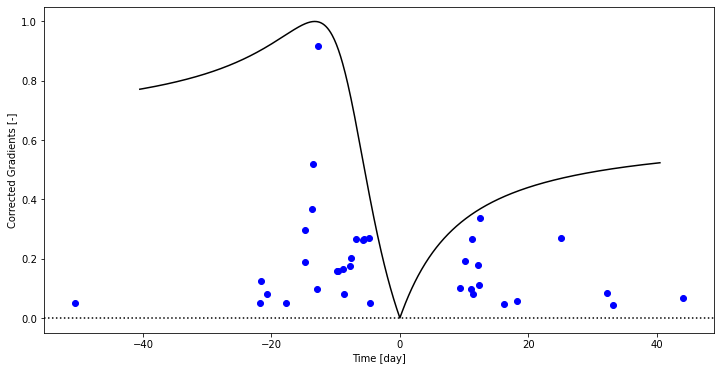

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(slope_times, gradients_corr, 'bo')
ax.plot(times, gradients, 'k-')
ax.set_xlabel('Time [day]')
ax.set_ylabel('Corrected Gradients [-]')
ax.set_ylim(-0.05, 1.05)
ax.axhline(y=0, color='k', ls=':')
plt.show()

## BeyonCE - Shallot Grid Analysis
Here we will use BeyonCE - Shallot Grid to explore the parameter space of circumplanetary disks that are possible solutions to this system, with the specified parameters. We will attempt to find better fit solutions that are smaller than the current solution and compare them appropriately.

#### Shallot Grid Creation
We attempt to load the shallot grid other wise generate it.

In [10]:
try:
    grid = ShallotGrid.load('coarse_grid')
except Exception:
    parameters = GridParameters(0, 1, 101, 0, 1, 251, 5, 201)
    grid = ShallotGrid(parameters, 5001)

100%|██████████| 2/2 [00:00<00:00, 367.31it/s]
2022-05-20 12:04:41,112 - INFO     - diagnose_fxfy_resolution: maximum deviation is 0.0088 - explore by plotting


#### Gradient Analysis
We compute the gradients of each solution at the given times and compare them to the measured values. We then compute the r.m.s. sum of all gradients at each grid point

In [11]:
grid.set_eclipse_parameters(eclipse_duration, transverse_velocity, limb_darkening)
grid.add_gradients(slope_times, slopes)
grid.determine_gradient_fit()

100%|██████████| 36/36 [00:03<00:00, 11.62it/s]


#### Extracting Best Fit Solutions
We extract the best fit solutions and plot the results.

In [20]:
rms, disk_radius, inclination, tilt, dx, dy = grid.extract_solutions(10000)
orbital_scale = grid.gradients[0].orbital_scale

2022-05-20 12:08:42,375 - INFO     - extract_solutions: extracting 10000 out of 1701148 possible solutions
100%|██████████| 10000/10000 [13:03<00:00, 12.76it/s]


We plot the best fit solutions.

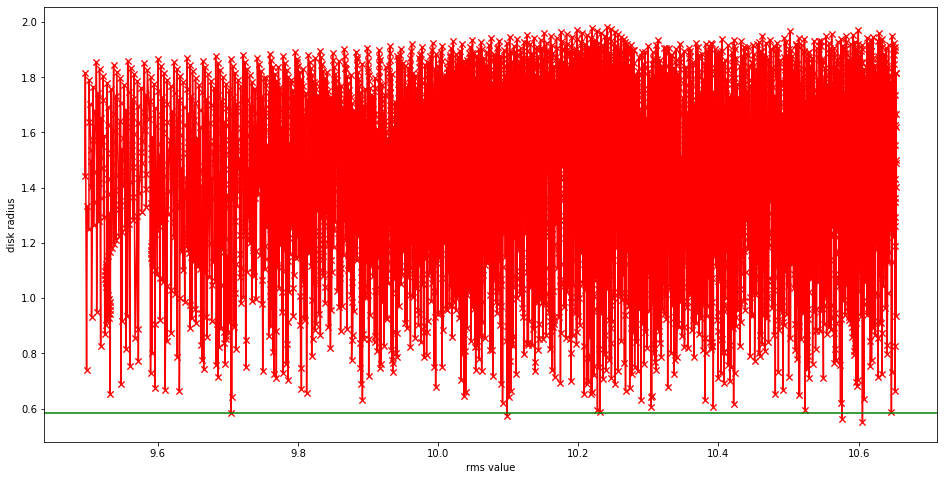

In [21]:
fig = plt.figure(figsize=(16, 8))
plt.plot(rms, disk_radius, 'r-x')
plt.gca().axhline(y=disk_radius_j1407, color='g')
plt.xlabel('rms value')
plt.ylabel('disk radius')
plt.show()

Sorting by disk radius size gives us the smallest disk solutions.

In [22]:
sort_mask = np.argsort(disk_radius)
disk_radius_sorted = disk_radius[sort_mask]
inclination_sorted = inclination[sort_mask]
tilt_sorted = tilt[sort_mask]
dx_sorted = dx[sort_mask]
dy_sorted = dy[sort_mask]
rms_sorted = rms[sort_mask]


Below we plot the extracted solutions sorted by disk radius.

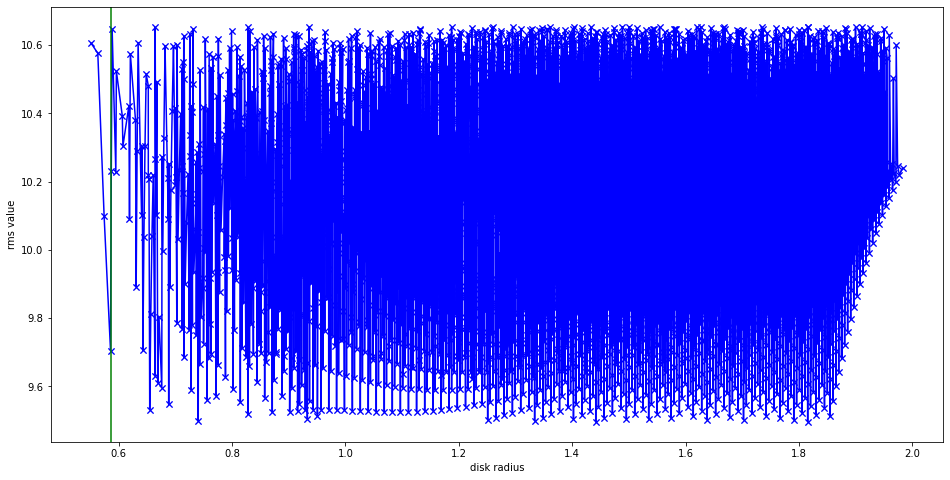

In [23]:
fig = plt.figure(figsize=(16, 8))
plt.plot(disk_radius_sorted, rms_sorted, 'b-x')
plt.gca().axvline(x=disk_radius_j1407, color='g')
plt.xlabel('disk radius')
plt.ylabel('rms value')
plt.show()

#### J1407 Ring System
Here we generate the J1407 ring system based on the values from the paper

In [1]:
j1407_rs_planet_radius = 0.5 # just for visualising the centre of the disk
j1407_rs_inner_radius = np.zeros(1)
j1407_rs_outer_radius = scale * disk_radius_j1407 * np.ones(1)
j1407_rs_transmission = 0.9 * np.ones(1) # to ensure transparency

j1407_rs = RingSystem(
    j1407_rs_planet_radius, 
    j1407_rs_inner_radius,
    j1407_rs_outer_radius, 
    j1407_rs_transmission,
    inclination_j1407,
    tilt_j1407
)               

NameError: name 'np' is not defined

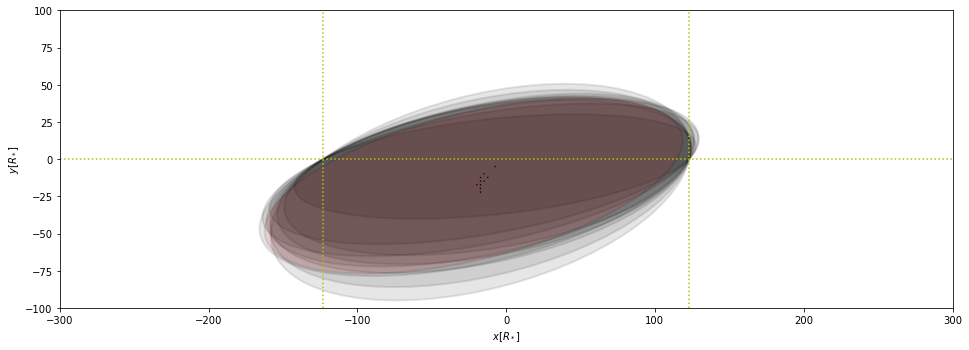

In [66]:
planet_radius = 0.5
inner_radius = np.zeros(1)
transmission = 0.9 * np.ones(1)

fig, ax = plt.subplots(1, figsize=(16, 12))
for k in range(20):
    if dy_sorted[k] > 0:
       continue

    rs = RingSystem(
        planet_radius, 
        inner_radius,
        scale * np.array([disk_radius_sorted[k]]),
        transmission,
        inclination_sorted[k],
        tilt_sorted[k]
    )

    ax = rs.plot(ax=ax, x_shift = scale * dx_sorted[k], y_shift = scale * dy_sorted[k])

ax = j1407_rs.plot(ax=ax, x_shift = scale * centroid_shift_j1407, y_shift = scale * impact_parameter_j1407, face_color='red')
ax.set_ylim(-100, 100)
ax.set_xlim(-300, 300)
ax.axvline(x = -0.5 * scale, color='y', ls=':')
ax.axvline(x =  0.5 * scale, color='y', ls=':')
ax.axhline(y = 0, color='y', ls=':')
plt.show()
    

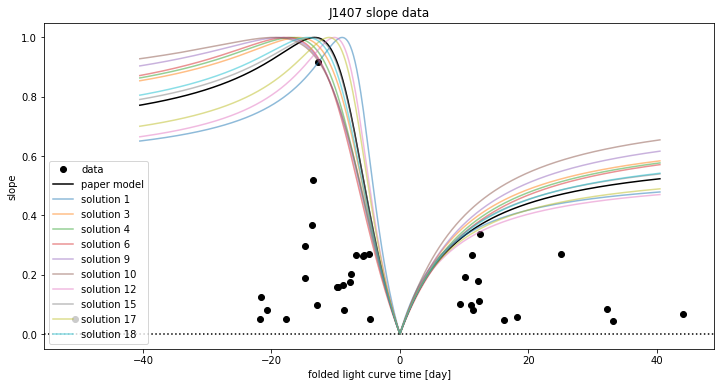

In [35]:
fig = plt.figure(figsize=(12, 6))
plt.plot(slope_times, gradients_corr, 'ko', label='data')
plt.plot(times, gradients, 'k-', label='paper model')
for k in range(20):
    if dy_sorted[k] > 0:
        continue
    solution_gradients = ring_gradients(positions, scale * dx_sorted[k], scale * dy_sorted[k], inclination_sorted[k], tilt_sorted[k])
    plt.plot(times, solution_gradients, alpha=0.5, label=f'solution {k}')
plt.ylim(-0.05, 1.05)
plt.gca().axhline(y=0, color='k', ls=':')
plt.xlabel('folded light curve time [day]')
plt.ylabel('slope')
plt.title('J1407 slope data')
plt.legend()
plt.show()

## Additional Analysis
In the previous analysis we left out the additional (and individual) scaling of each measured gradient by the transmission difference. Note that this is a precarious practice and has some limitations.
1. The scaled gradient can not exceed 1.
2. The transmission change should always be an upper bound to prevent over estimation of the measured gradients and cut away too much of the parameter space.
3. When unsure use a transmission change of 1.

In [51]:
grid_analysis = ShallotGrid.load('coarse_grid')
grid_analysis.set_eclipse_parameters(eclipse_duration, transverse_velocity, limb_darkening)
grid_analysis.add_gradients(slope_times, slopes)
grid_analysis.determine_gradient_fit()

100%|██████████| 2/2 [00:00<00:00, 264.27it/s]
2022-05-20 15:19:21,067 - INFO     - diagnose_fxfy_resolution: maximum deviation is 0.0088 - explore by plotting
100%|██████████| 36/36 [00:03<00:00,  9.10it/s]


#### SuperWASP Eclipse
We take a look at the light curve of J1407.

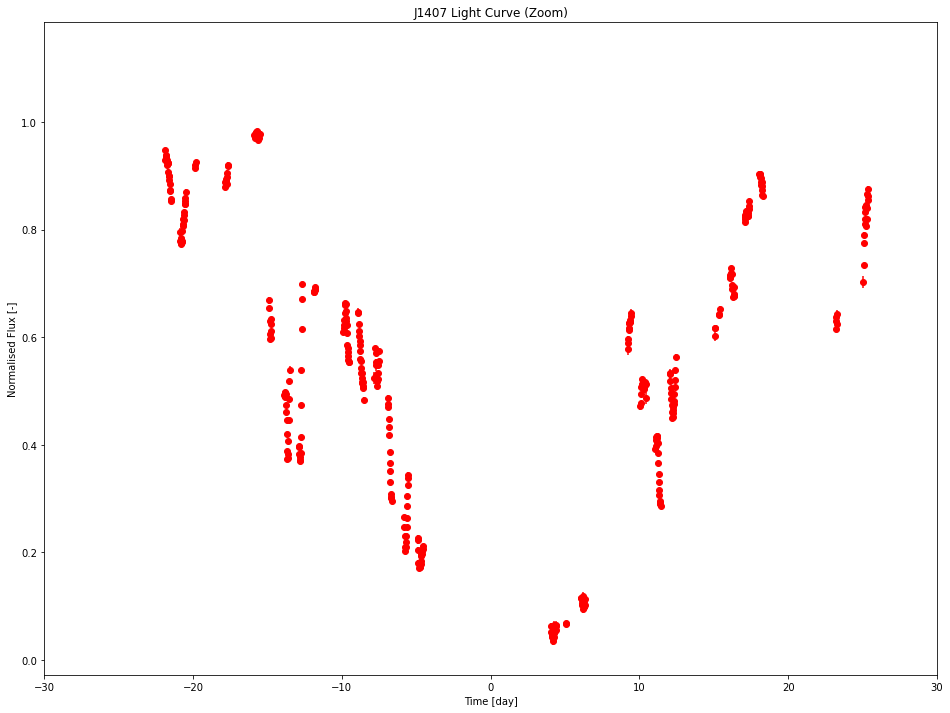

In [52]:
fig, ax = plt.subplots(figsize=(16,12))
ax.errorbar(time, flux, yerr=error, fmt='o', color='r')
ax.set_xlabel('Time [day]')
ax.set_ylabel('Normalised Flux [-]')
ax.set_title('J1407 Light Curve (Zoom)')
ax.set_xlim(-30, 30)
plt.show()

We look at all the individual nights to visualise the gradients and determine the transmission changes manually.

In [53]:
ylims = 3*[(0.8, 1.0)] + 1*[(0.7, 0.9)] + 1*[(0.8, 1.0)] + 2*[(0.4, 0.8)] + 4*[(0.3, 0.8)] + 6*[(0.4, 0.8)] + \
        1*[(0.2, 0.6)] + 2*[(0.1, 0.5)] + 2*[(0.1, 0.4)] + 2*[(0.4, 0.8)] + 6*[(0.2, 0.6)] + 1*[(0.6, 0.8)] + \
        1*[(0.7, 1.0)] + 1*[(0.6, 1.0)] + 3*[(0.8, 1.1)]

Plot the nightly gradients

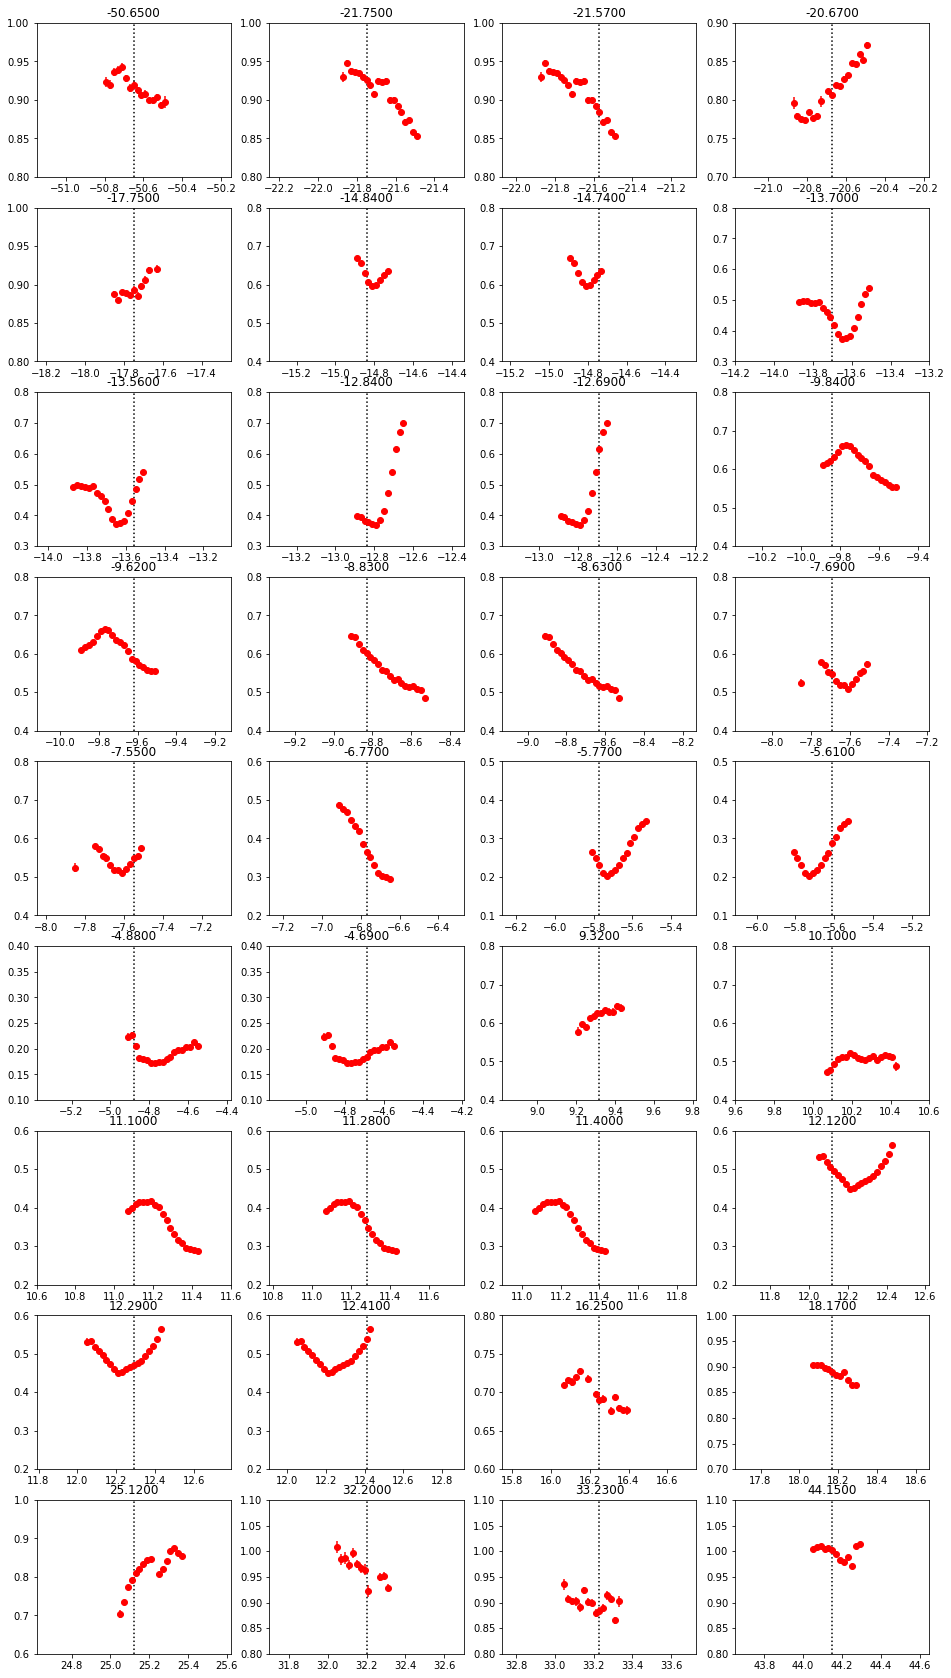

In [54]:
fig, axes = plt.subplots(9, 4, figsize=(16, 30))

for slope_time, ax, ylim in zip(slope_times, axes.flatten(), ylims):
        ax.errorbar(time, flux, yerr=error, fmt='o', color='r')
        ax.set_xlim(slope_time - 0.5, slope_time + 0.5)
        ax.axvline(slope_time, ls=':', color='k')
        ax.set_title(f"{slope_time:.4f}")
        ax.set_ylim(ylim)
plt.show()

Observing the above subplots gives the following transmission changes

In [55]:
transmission_changes = np.array([1.00, 1.00, 1.00, 0.25, 0.15, 0.40, 0.40, 1.00, 0.70, 
                                 0.70, 1.00, 0.70, 0.70, 1.00, 1.00, 0.50, 0.50, 1.00, 
                                 0.80, 0.80, 0.85, 0.85, 1.00, 0.60, 0.50, 0.60, 0.40, 
                                 0.60, 0.60, 0.60, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00])

In [56]:
grid_analysis.update_gradient_scaling(transmission_changes=transmission_changes)
measured_positions, scaled_gradients, measured_errores, _ = grid_analysis.get_gradients(masked=True)
measured_times = - measured_positions * eclipse_duration

2022-05-20 15:20:43,409 - INFO     - _reset_gradient_fit: gradient fit has been cleared


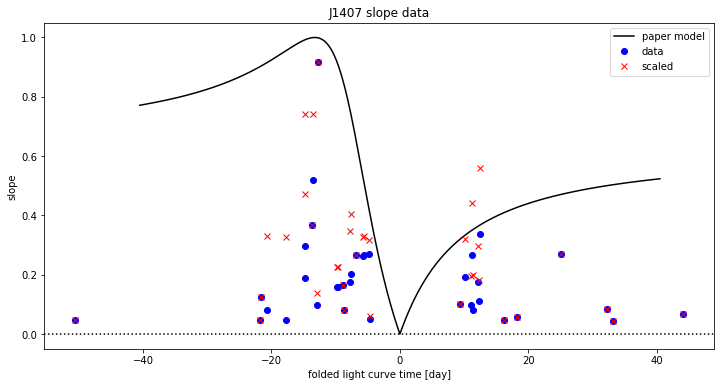

In [60]:
fig = plt.figure(figsize=(12, 6))
plt.errorbar(slope_times, gradients_corr,  fmt='o', color='b', label='data')
plt.errorbar(slope_times, scaled_gradients, fmt='x', color='r', label='scaled')
plt.plot(times, gradients, 'k-', label='paper model')
plt.gca().axhline(y=0, color='k', ls=':')
plt.xlabel('folded light curve time [day]')
plt.ylabel('slope')
plt.title('J1407 slope data')
plt.legend()
plt.show()

We can already see that the transmission scaling has a significant effect on the possible solutions as several light curves are now above the model determined in Kenworthy & Mamajek 2015.

#### Solution Extraction
Once again we extract solutions and plot some of the best fit solutions with the smallest disk sizes.

In [61]:
grid_analysis.set_eclipse_parameters(eclipse_duration, transverse_velocity, limb_darkening)
grid_analysis.add_gradients(slope_times, slopes, transmission_changes=transmission_changes)
grid_analysis.determine_gradient_fit()

2022-05-20 15:23:39,097 - INFO     - set_eclipse_parameters: gradients set to None due to dependency on eclipse duration
100%|██████████| 36/36 [00:03<00:00, 10.70it/s]


In [62]:
rms_analysis, disk_radius_analysis, inclination_analysis, tilt_analysis, dx_analysis, dy_analysis = grid_analysis.extract_solutions(2000)
orbital_scale_analysis = grid_analysis.gradients[0].orbital_scale

2022-05-20 16:00:50,568 - INFO     - extract_solutions: extracting 2000 out of 1624252 possible solutions
100%|██████████| 2000/2000 [03:06<00:00, 10.73it/s]


In [63]:
sort_mask_analysis = np.argsort(disk_radius_analysis)
disk_radius_analysis_sorted = disk_radius_analysis[sort_mask_analysis]
inclination_analysis_sorted = inclination_analysis[sort_mask_analysis]
tilt_analysis_sorted = tilt_analysis[sort_mask_analysis]
dx_analysis_sorted = dx_analysis[sort_mask_analysis]
dy_analysis_sorted = dy_analysis[sort_mask_analysis]
rms_analysis_sorted = rms_analysis[sort_mask_analysis]


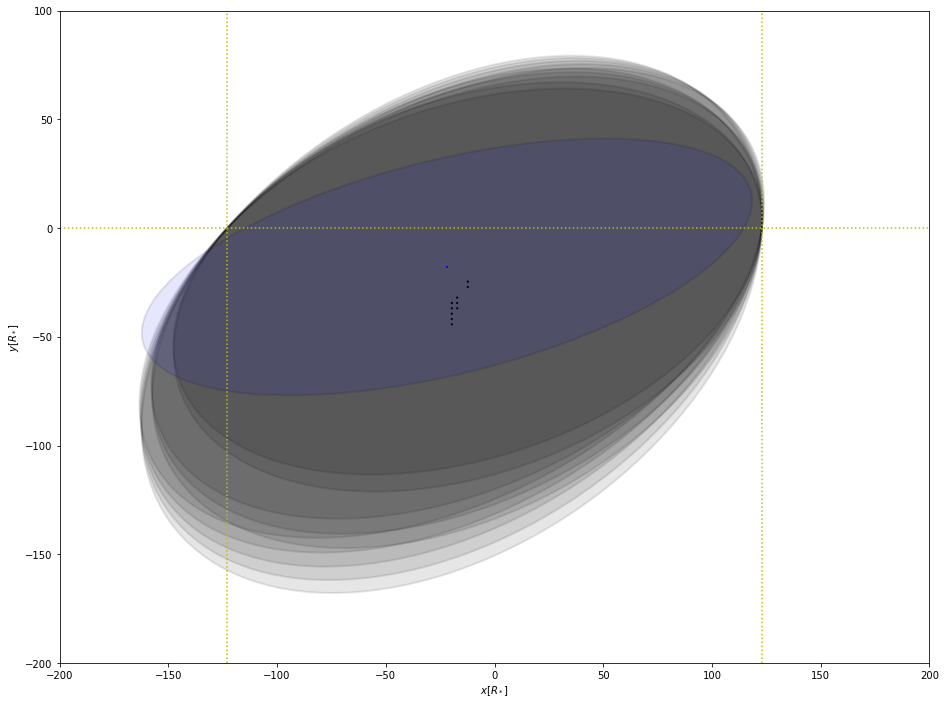

In [69]:
planet_radius = 0.5
inner_radius = np.zeros(1)
transmission = 0.9 * np.ones(1)

fig, ax = plt.subplots(1, figsize=(16, 12))
for k in range(20):
    if dy_analysis_sorted[k] > 0:
       continue

    rs = RingSystem(
        planet_radius, 
        inner_radius,
        scale * np.array([disk_radius_analysis_sorted[k]]),
        transmission,
        inclination_analysis_sorted[k],
        tilt_analysis_sorted[k]
    )

    ax = rs.plot(ax=ax, x_shift = scale * dx_analysis_sorted[k], y_shift = scale * dy_analysis_sorted[k])

ax = j1407_rs.plot(ax=ax, x_shift = scale * centroid_shift_j1407, y_shift = scale * impact_parameter_j1407, face_color='blue')
ax.set_ylim(-200, 100)
ax.set_xlim(-200, 200)
ax.axvline(x = -0.5 * scale, color='y', ls=':')
ax.axvline(x =  0.5 * scale, color='y', ls=':')
ax.axhline(y = 0, color='y', ls=':')
plt.show()


In [2]:
fig = plt.figure(figsize=(12, 6))
plt.errorbar(slope_times, gradients_corr, fmt='o', color='b', label='orbital scaled')
plt.errorbar(slope_times, gradients_corr / transmission_changes, fmt='o', color='y', label='transmission scaled')
plt.plot(times, gradients, 'k-', label='paper model')
for k in range(20):
    if dy_sorted[k] > 0:
        continue
    solution_gradients = ring_gradients(positions, scale * dx_analysis_sorted[k], scale * dy_analysis_sorted[k], 
        inclination_analysis_sorted[k], tilt_analysis_sorted[k])
    plt.plot(times, solution_gradients, alpha=0.5, label=f'solution {k}')
plt.ylim(-0.05, 1)
plt.gca().axhline(y=0, color='k', ls=':')
plt.xlabel('folded light curve time [day]')
plt.ylabel('slope')
plt.title('J1407 slope data')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

#### Comparison
Here the results are compared for transmission scaling - yes and no.

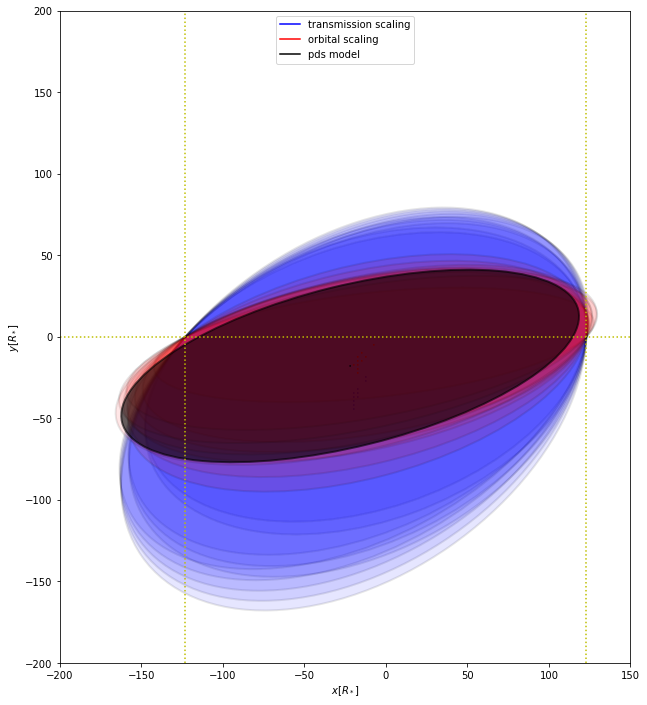

In [81]:
planet_radius = 0.5
inner_radius = np.zeros(1)
transmission = 0.9 * np.ones(1)

fig, ax = plt.subplots(1, figsize=(16, 12))
for k in range(20):
    if dy_analysis_sorted[k] > 0:
       continue

    rs = RingSystem(
        planet_radius, 
        inner_radius,
        scale * np.array([disk_radius_analysis_sorted[k]]),
        transmission,
        inclination_analysis_sorted[k],
        tilt_analysis_sorted[k]
    )

    ax = rs.plot(ax=ax, x_shift = scale * dx_analysis_sorted[k], y_shift = scale * dy_analysis_sorted[k], face_color='blue')

for k in range(20):
    if dy_sorted[k] > 0:
       continue

    rs = RingSystem(
        planet_radius, 
        inner_radius,
        scale * np.array([disk_radius_sorted[k]]),
        transmission,
        inclination_sorted[k],
        tilt_sorted[k]
    )

    ax = rs.plot(ax=ax, x_shift = scale * dx_sorted[k], y_shift = scale * dy_sorted[k], face_color='red')
j1407_rs.rings[0].transmission = 0.4
ax = j1407_rs.plot(ax=ax, x_shift = scale * centroid_shift_j1407, y_shift = scale * impact_parameter_j1407, face_color='black')
ax.set_ylim(-200, 200)
ax.set_xlim(-200, 150)
ax.plot(-1000, -100, 'b-', label='transmission scaling')
ax.plot(-1000, -100, 'r-', label='orbital scaling')
ax.plot(-1000, -100, 'k-', label='j1407 model')
ax.axvline(x = -0.5 * scale, color='y', ls=':')
ax.axvline(x =  0.5 * scale, color='y', ls=':')
ax.axhline(y = 0, color='y', ls=':')
ax.legend()
plt.show()


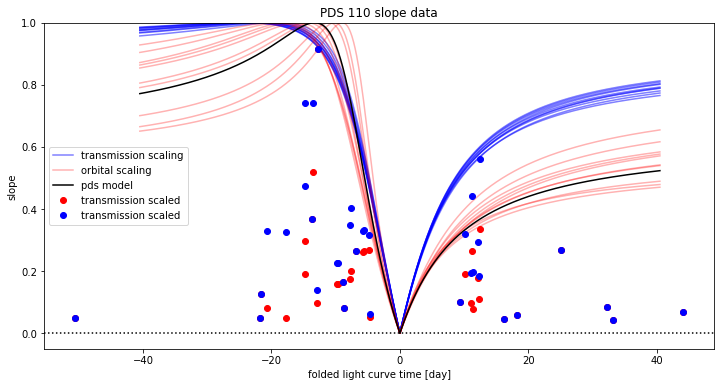

In [77]:
fig = plt.figure(figsize=(12, 6))
plt.errorbar(slope_times, gradients_corr, fmt='o', color='r', label='transmission scaled')
plt.errorbar(slope_times, gradients_corr / transmission_changes, fmt='o', color='b', label='transmission scaled')
transmission_label = 'transmission scaling'
for k in range(20):
    if dy_sorted[k] > 0:
        continue
    solution_gradients = ring_gradients(positions, scale * dx_analysis_sorted[k], scale * dy_analysis_sorted[k], 
        inclination_analysis_sorted[k], tilt_analysis_sorted[k])
    plt.plot(times, solution_gradients, 'b-', alpha=0.5, label=transmission_label)
    transmission_label = None
orbital_label = 'orbital scaling'
for k in range(20):
    if dy_sorted[k] > 0:
        continue
    solution_gradients = ring_gradients(positions, scale * dx_sorted[k], scale * dy_sorted[k], inclination_sorted[k], tilt_sorted[k])
    plt.plot(times, solution_gradients, 'r-', alpha=0.3, label=orbital_label)
    orbital_label = None
plt.plot(times, gradients, 'k-', label='j1407 model')
plt.ylim(-0.05, 1)
plt.gca().axhline(y=0, color='k', ls=':')
plt.xlabel('folded light curve time [day]')
plt.ylabel('slope')
plt.title('J1407 slope data')
plt.legend()
plt.show()